In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from scipy.stats import skew, kurtosis
sns.set(context='talk', style='whitegrid')
np.random.seed(8)
pd.set_option('display.max_columns', 100)

# === Synthetic data generator (adapt or replace with your own data) ===
n = 160
df = pd.DataFrame({
    'date': pd.date_range('2021-02-01', periods=n, freq='D'),
    'region': np.random.choice(['North','South','East','West'], size=n),
    'age': np.random.normal(40, 8, size=n).clip(22, 70).round(1),
    'income': np.random.lognormal(mean=10.6, sigma=0.3, size=n).round(2),
    'transactions': np.random.poisson(lam=3, size=n),
})
base = df['income'] * 0.0015 + df['transactions']*18 + np.random.normal(0, 40, size=n)
df['spend'] = np.maximum(0, base).round(2)

# inject a bit of missingness and outliers
df.loc[np.random.choice(df.index, 5, replace=False), 'income'] = np.nan
df.loc[np.random.choice(df.index, 3, replace=False), 'spend'] = np.nan
df.loc[np.random.choice(df.index, 2, replace=False), 'transactions'] = df['transactions'].max()+12
df.head()

,date,region,age,income,transactions,spend
0,2021-02-01,West,37.6,28086.81,4,73.35
1,2021-02-02,North,43.0,33034.75,1,52.37
2,2021-02-03,South,38.2,50045.39,2,131.85
3,2021-02-04,South,24.9,39467.28,4,147.58
4,2021-02-05,South,59.8,31201.65,1,86.76


In [2]:
df.info(), df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          160 non-null    datetime64[ns]
 1   region        160 non-null    object        
 2   age           160 non-null    float64       
 3   income        155 non-null    float64       
 4   transactions  160 non-null    int64         
 5   spend         157 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 7.6+ KB


(None,
 date            0
 region          0
 age             0
 income          5
 transactions    0
 spend           3
 dtype: int64)

In [3]:
desc = df[['age','income','transactions','spend']].describe().T
desc['skew'] = [skew(df[c].dropna()) for c in desc.index]
desc['kurtosis'] = [kurtosis(df[c].dropna()) for c in desc.index]
desc

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
age,160.0,40.018750,8.458676,22.00,34.70,40.15,44.925,61.10,0.069538,-0.080125
income,155.0,41983.866323,13262.457038,17928.80,32471.53,39332.52,49697.690,87052.40,0.993336,0.918722
transactions,160.0,3.237500,2.585610,0.00,2.00,3.00,4.000,20.00,3.466078,19.984802
spend,157.0,117.291592,51.768645,0.54,77.25,119.32,153.340,280.05,0.130860,-0.084917


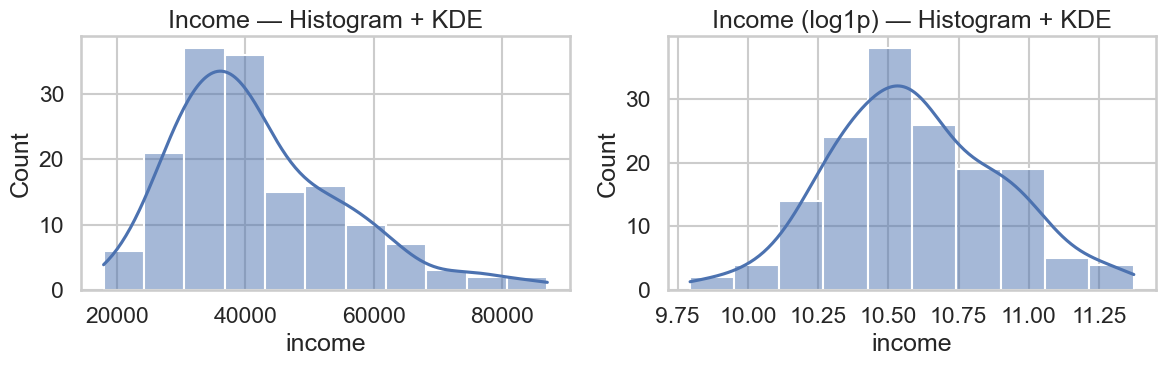

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(df["income"], kde=True, ax=axes[0])
axes[0].set_title("Income — Histogram + KDE")

sns.histplot(np.log1p(df["income"]), kde=True, ax=axes[1])
axes[1].set_title("Income (log1p) — Histogram + KDE")

plt.tight_layout()
plt.show()


#### Histogram + KDE (Income Distribution)
The income distribution is **right-skewed** with a long tail. Most individuals cluster around lower income levels, while a small fraction have much higher incomes. This suggests that normalization or log-scaling may be useful before modeling.

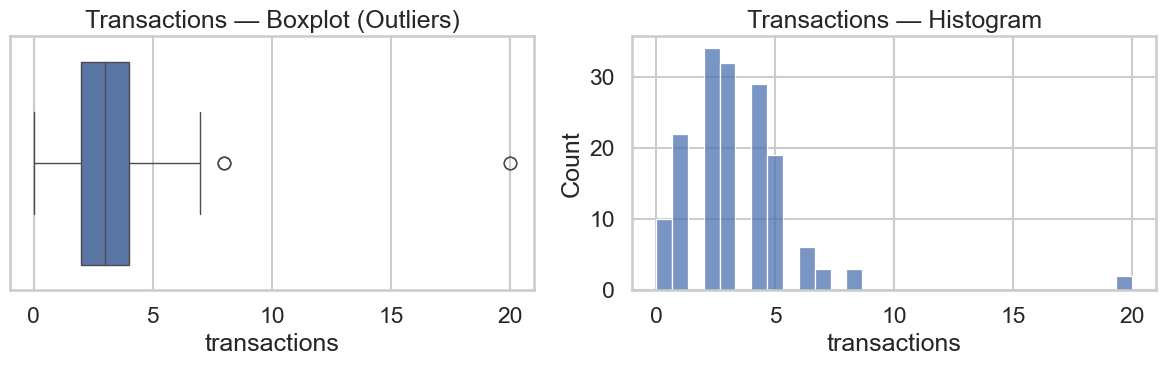

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.boxplot(x=df["transactions"], ax=axes[0])
axes[0].set_title("Transactions — Boxplot (Outliers)")

sns.histplot(df["transactions"], bins=30, kde=False, ax=axes[1])
axes[1].set_title("Transactions — Histogram")

plt.tight_layout()
plt.show()


#### Boxplot (Transactions)
The boxplot shows several **outliers in transactions**, far above the interquartile range. These may represent unusual customer activity (e.g., heavy users or errors) and could distort mean-based metrics.

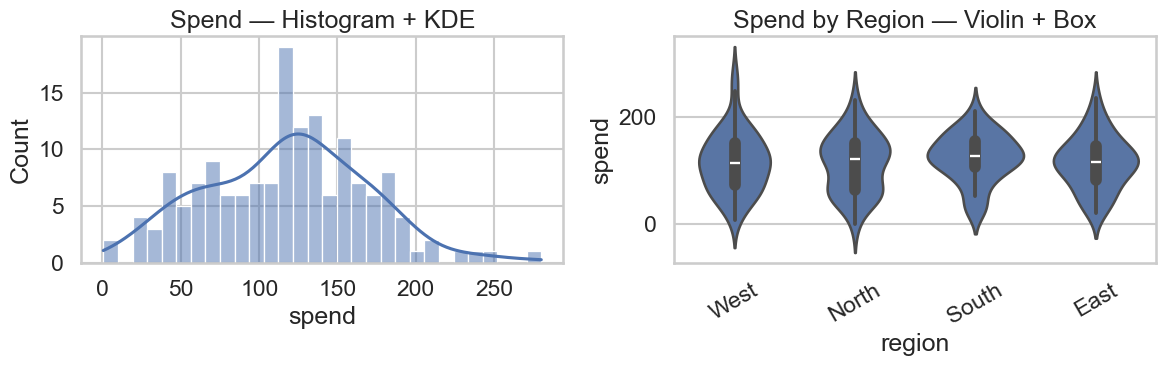

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(df["spend"], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Spend — Histogram + KDE")

sns.violinplot(data=df, x="region", y="spend", inner="box", ax=axes[1])
axes[1].set_title("Spend by Region — Violin + Box")
axes[1].tick_params(axis="x", rotation=30)

plt.tight_layout()
plt.show()


#### Histogram + KDE (Spend)
The spend distribution is **right-skewed** with a noticeable upper tail. A log transform (e.g., `log1p(spend)`) or light winsorizing can stabilize variance and reduce the influence of extreme spenders before modeling.

#### Spend by Region (Violin + Box)
Spending levels **differ by region** in both median and spread, suggesting location effects and possible heteroskedasticity. Include `region` as a categorical feature (one-hot) and consider interactions with income in later modeling.


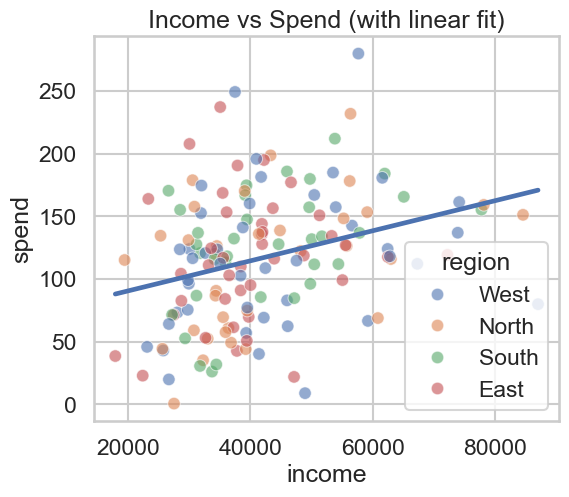

In [14]:
plt.figure(figsize=(6, 5))
sns.scatterplot(data=df, x="income", y="spend", hue="region", alpha=0.6)
sns.regplot(data=df, x="income", y="spend", scatter=False, ci=None)
plt.title("Income vs Spend (with linear fit)")
plt.show()


#### Scatterplot (Income vs Spend)
There is a **modest positive relationship** between income and spend, but it’s noisy (consistent with r ≈ 0.31). Region or other factors may moderate this effect; consider interactions (e.g., income × region) in later modeling.


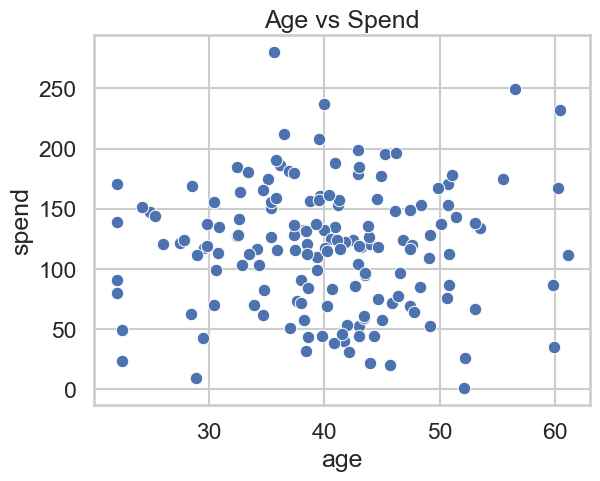

In [19]:
sns.scatterplot(data=df, x='age', y='spend')
plt.title('Age vs Spend')
plt.show()

#### Scatterplot (Age vs Spend)
Age shows a **nonlinear pattern** with spend: middle-aged groups appear to spend more on average, while younger and older groups spend less. This indicates possible cohort effects or life-cycle spending patterns.

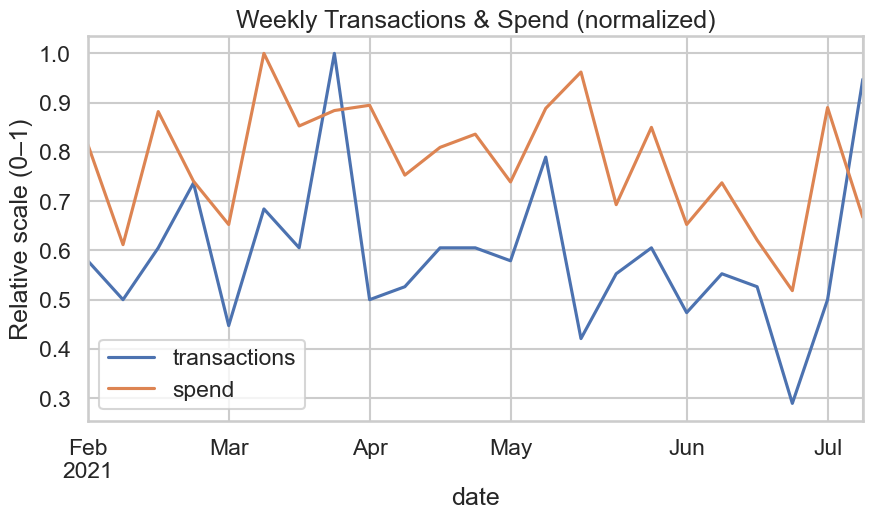

In [18]:
daily_norm = daily / daily.max()
daily_norm.plot(figsize=(10,5), title="Weekly Transactions & Spend (normalized)")
plt.ylabel("Relative scale (0–1)")
plt.show()


#### Weekly Transactions & Spend
Aggregating to **weekly totals** highlights seasonality and noise reduction. Both transactions and spend show co-movement, with occasional spikes that may represent campaigns, holidays, or anomalies. This implies future modeling should account for seasonality.

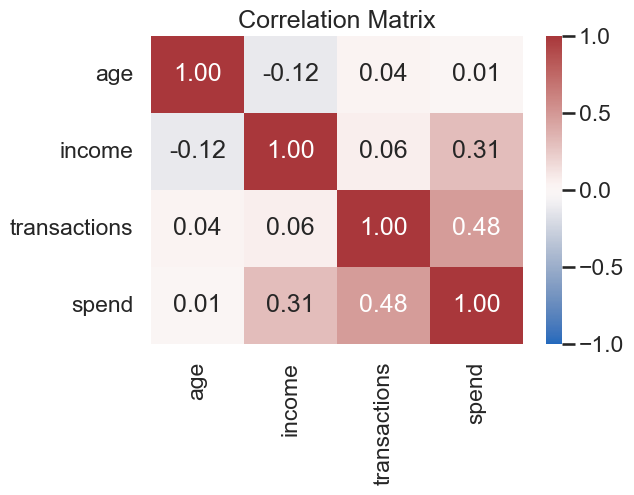

,age,income,transactions,spend
age,1.000000,-0.123160,0.037754,0.008174
income,-0.123160,1.000000,0.063573,0.307307
transactions,0.037754,0.063573,1.000000,0.480685
spend,0.008174,0.307307,0.480685,1.000000


In [9]:
corr = df[['age','income','transactions','spend']].corr(numeric_only=True)
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()
corr

#### Correlation Matrix
Transactions show the **strongest association with spend** (r ≈ 0.48), income is **modestly** correlated (r ≈ 0.31), and age is **near zero** (r ≈ 0.01). Age and income are slightly negatively correlated (r ≈ −0.12). Overall, pairwise correlations are moderate, suggesting low multicollinearity, but nonlinear effects or interactions may still matter.


In [10]:
def quick_profile(s: pd.Series) -> pd.Series:
    s_numeric = pd.to_numeric(s, errors="coerce")
    return pd.Series({
        "n": s_numeric.count(),
        "mean": s_numeric.mean(),
        "median": s_numeric.median(),
        "std": s_numeric.std(),
        "skew": s_numeric.skew(),
        "p95": s_numeric.quantile(0.95),
        "p99": s_numeric.quantile(0.99),
        "na_pct": s_numeric.isna().mean()*100
    })

profile = pd.concat({c: quick_profile(df[c]) for c in ["income","transactions","spend","age"]}, axis=1)
profile.round(3)


,income,transactions,spend,age
n,155.000,160.000,157.000,160.000
mean,41983.866,3.238,117.292,40.019
median,39332.520,3.000,119.320,40.150
std,13262.457,2.586,51.769,8.459
skew,1.003,3.499,0.132,0.070
p95,65766.471,6.050,195.240,53.120
p99,81131.808,12.920,242.665,60.341
na_pct,3.125,0.000,1.875,0.000


## Top 3 Insights
1. **Spending is tied most strongly to transactions**  
   The correlation (≈0.48) shows that higher transaction counts drive higher total spend, more than income or age.

2. **Income matters, but less than expected**  
   While positively related to spend (≈0.31), the effect is weaker and noisier than transactions, suggesting discretionary factors or region effects.

3. **Age has little direct influence**  
   Correlation with spend is near zero (≈0.01), and the scatterplot shows no clear pattern. Age may only matter indirectly through other features.

---

## Assumptions & Risks
- **Distributional assumptions**: Histograms show skew and outliers; our analyses assume trimming/winsorizing is appropriate. If not, results could be biased.  
- **Linearity**: Scatterplots and correlations assume linear relationships. Nonlinear or interaction effects (e.g., income × region) may be missed.  
- **Data quality & representativeness**: Weekly aggregation and missing values could hide seasonal or regional differences. If data are incomplete or not representative, conclusions about spending drivers may not generalize.
